## **Exercice 2**

1. Sélection et import du jeux de données `"https://cifre.s3.eu-north-1.amazonaws.com/data_1.csv"`, identifiez l’anomalie.

In [129]:
# URL du jeu de données sélectionné
url_data = "https://cifre.s3.eu-north-1.amazonaws.com/data_1.csv"

# Chargement du jeu de données
df2 = pd.read_csv(url_data)

In [82]:
df2

,content
0,Women's football legend Mia Hamm has played h...
1,Arsenal boss Arsene Wenger says he has no pla...
2,"The trial of Bernie Ebbers, former chief exec..."
3,Shares in storage and delivery firm Exel clos...
4,"Hollywood stars including Spike Lee, Burt Rey..."
...,...
2420,"Richard Attias, en octobre 2015 à Paris. JACQU..."
2421,Betty Boothroyd has said the House of Lords n...
2422,Rapper Eminem has denied Elvis his fourth num...
2423,Près de 3 100 hospitalisations pour une insuff...


In [83]:
df2.shape

(2425, 1)

In [86]:
df2.describe(include='all').transpose().head(20)

,count,unique,top,freq
content,2425,2289,"The BBC should steer away from ""demonising"" e...",2


In [87]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2425 entries, 0 to 2424
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2425 non-null   object
dtypes: object(1)
memory usage: 19.1+ KB


In [130]:
col = 'content'
# Count duplicate rows
n_duplicates = df2.duplicated().sum()
print("Number of duplicate rows:", n_duplicates)

Number of duplicate rows: 136


In [131]:
# Suppression des doublons
df2.drop_duplicates(inplace=True)

In [132]:
# Vérification de l'aspect codage des caractères
def is_non_ascii(text):
    try:
        text.encode('ascii')
        return False
    except UnicodeEncodeError:
        return True

In [133]:
df2["is_ascii"] = df2["content"].apply(is_non_ascii)
df2["is_ascii"].value_counts()

,count
is_ascii,
False,1479
True,810


In [134]:
# Conversion de la colonne "content" en string ( juste pour éviter des erreurs du type coerce)
df2["content"] = df2["content"].astype(str)

# Distribution de la longueur des avis

In [120]:
import warnings
warnings.filterwarnings("ignore")

In [135]:
# Calcul de la longueur moyenne des avis
df2["review_length"] = df2["content"].apply(lambda x: len(x.split()))

# Longueur moyenne
mean_length = df2["review_length"].mean()

print("Longueur moyenne des avis :", mean_length)

Longueur moyenne des avis : 392.99563128003496


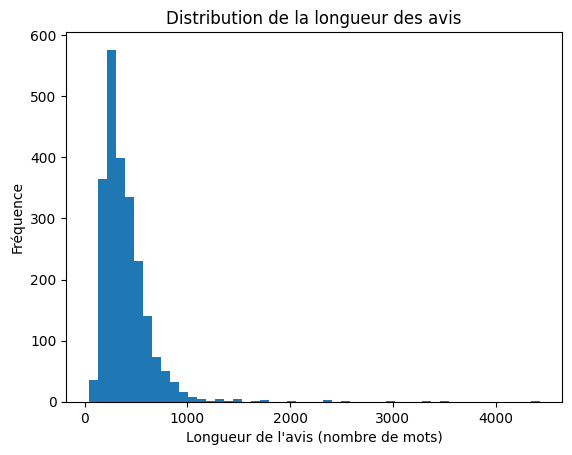

In [136]:
# Histogramme de la longueur des avis
plt.hist(df2["review_length"], bins = 50 )
plt.xlabel("Longueur de l'avis (nombre de mots)")
plt.ylabel("Fréquence")
plt.title("Distribution de la longueur des avis")
plt.show()

In [137]:
# Définir le seuil maximum
SEUIL_MAX = 1000

# Créer un masque booléen qui est VRAI pour les lignes dont la longueur est inférieure ou égale à 1000
# et FAUX pour les lignes à supprimer (longueur > 1000)
mask = df2['review_length'] <= SEUIL_MAX

# Appliquer le masque pour conserver uniquement les lignes souhaitées
df3 = df2[mask].copy() # Utiliser .copy() est une bonne pratique

# Afficher les informations pour vérifier le nettoyage
print(f"Nombre d'avis dans le DataFrame original : {len(df2)}")
print(f"Nombre d'avis conservés (longueur <= {SEUIL_MAX}) : {len(df3)}")

# Afficher la longueur maximale dans le nouveau DataFrame pour vérification
if not df3.empty:
    max_length_filtre = df3['review_length'].max()
    print(f"Longueur maximale dans le DataFrame filtré : {max_length_filtre}")

Nombre d'avis dans le DataFrame original : 2289
Nombre d'avis conservés (longueur <= 1000) : 2252
Longueur maximale dans le DataFrame filtré : 998


In [138]:
df3.head()

,content,is_ascii,review_length
0,Women's football legend Mia Hamm has played h...,False,191
1,Arsenal boss Arsene Wenger says he has no pla...,False,230
2,"The trial of Bernie Ebbers, former chief exec...",True,202
3,Shares in storage and delivery firm Exel clos...,True,202
4,"Hollywood stars including Spike Lee, Burt Rey...",False,372


In [139]:
# Vérifions que toutes les lignes sont de la même langue
df3['Language'] = df3['content'].apply(language_detector)

In [140]:
df3.Language.value_counts()

,count
Language,
en,2072
fr,180


## Remarque

Nous remarquons que les textes sont en deux langues : français et anglais.

Puisque la grande majorité des en anglais, nous allons simplement garder les lignes dont la langue est l'anglais

In [141]:
df3 = df3[df3['Language'] == 'en'].copy()

In [142]:
#  Retrait tous les caractères de ponctuation pour normaliser le texte.
df3["text_clean"] = df3["content"].str.translate(str.maketrans("", "", string.punctuation))
# Application de stopwords pour éliminer les mots peu informatifs, comme les articles et les conjonctions.
stopwords_en = set(stopwords.words("english"))

def clean_text(text):
    # enlever la ponctuation
    text = re.sub(r"[^\w\s]", " ", text.lower())
    # tokeniser (split simple)
    tokens = text.split()
    # retirer les stopwords
    tokens = [t for t in tokens if t not in stopwords_en]
    return " ".join(tokens)

df3["text_clean"] = df3["text_clean"].apply(clean_text)

# **LDA**

In [143]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Fix NLTK
nltk.download("punkt")
nltk.download("punkt_tab")
def tokenize_text_clean(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_en and len(t) > 2]
    return tokens

df3["tokens"] = df3["text_clean"].apply(tokenize_text_clean)
df3[["text_clean", "tokens"]].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text_clean,tokens
0,womens football legend mia hamm played final g...,"[womens, football, legend, mia, hamm, played, ..."
1,arsenal boss arsene wenger says plans sign new...,"[arsenal, boss, arsene, wenger, says, plans, s..."
2,trial bernie ebbers former chief executive ban...,"[trial, bernie, ebbers, former, chief, executi..."
3,shares storage delivery firm exel closed 9 two...,"[shares, storage, delivery, firm, exel, closed..."
4,hollywood stars including spike lee burt reyno...,"[hollywood, stars, including, spike, lee, burt..."


In [112]:
!pip install -q gensim pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 73.0 MB/s eta 0:00:00


In [114]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(df2["tokens"])

dictionary.filter_extremes(no_below=5, no_above=0.5)

# corpus Bag-of-Words
corpus = [dictionary.doc2bow(tokens) for tokens in df2["tokens"]]

len(dictionary), len(corpus)

(9014, 2092)

In [115]:
from gensim.models.ldamodel import LdaModel

num_topics = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

# Affichage de  nos topics
for i, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {i}: {topic}\n")

Topic 0: 0.013*"government" + 0.010*"people" + 0.008*"one" + 0.008*"new" + 0.007*"without" + 0.006*"threat" + 0.005*"like" + 0.005*"law" + 0.005*"could" + 0.005*"says"

Topic 1: 0.016*"party" + 0.013*"kilroysilk" + 0.012*"ukip" + 0.007*"blair" + 0.007*"election" + 0.007*"people" + 0.007*"new" + 0.006*"parties" + 0.006*"one" + 0.006*"brown"

Topic 2: 0.008*"world" + 0.007*"olympic" + 0.007*"european" + 0.007*"indoor" + 0.006*"race" + 0.006*"win" + 0.006*"champion" + 0.005*"jump" + 0.005*"new" + 0.005*"long"

Topic 3: 0.013*"year" + 0.011*"sales" + 0.009*"last" + 0.007*"new" + 0.006*"economy" + 0.006*"2004" + 0.006*"growth" + 0.005*"show" + 0.005*"however" + 0.005*"mini"

Topic 4: 0.008*"budget" + 0.008*"election" + 0.007*"chancellor" + 0.007*"oil" + 0.006*"labour" + 0.006*"tax" + 0.005*"economic" + 0.005*"economy" + 0.005*"could" + 0.005*"crude"

Topic 5: 0.015*"people" + 0.008*"users" + 0.008*"online" + 0.008*"many" + 0.007*"could" + 0.007*"net" + 0.007*"new" + 0.006*"broadband" + 0.00

In [116]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.052233  0.029954       1        1  16.373957
6      0.209318  0.029146       2        1  13.987051
9      0.135319 -0.201906       3        1  11.949323
7     -0.135794  0.068558       4        1  11.825854
0     -0.016304  0.139483       5        1   9.282623
4     -0.153535 -0.100523       6        1   9.139802
3     -0.027344 -0.105877       7        1   8.755328
8     -0.128260 -0.109155       8        1   7.001774
2      0.210127  0.049228       9        1   6.036024
1     -0.041293  0.201093      10        1   5.648263, topic_info=            Term         Freq        Total Category  logprob  loglift
25          game   785.000000   785.000000  Default  30.0000  30.0000
1694       party   646.000000   646.000000  Default  29.0000  29.0000
284       people  1820.000000  1820.000000  Default  28.0000  28.0000
477   government  1297.000000  1297.000000  Default  27.0000  27.0000
1631    election   628.000000   628.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
477   government   112.275529  1297.610263  Topic10  -5.2555   0.4265
1707      public    82.234396   506.716576  Topic10  -5.5669   1.0554
727          get    80.724514   831.656282  Topic10  -5.5854   0.5414
437      british    75.562711   677.885358  Topic10  -5.6515   0.6798
58           two    72.401044  1111.746928  Topic10  -5.6942   0.1424

[716 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4677      8  0.960252     14bn
1436      6  0.964103   150000
797       9  0.975019    1500m
798       1  0.143268     2004
798       2  0.061716     2004
...     ...       ...      ...
64        8  0.000902    years
64        9  0.030655    years
64       10  0.010819    years
2534      6  0.968912  yugansk
2535      6  0.990362    yukos

[1831 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 10, 8, 1, 5, 4, 9, 3, 2])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## **Commentaire**

Notre analyse, via LDA, révèle des ensembles de sujets correspondants à diverses sections du journalisme. Plusieurs sujets sont aisément compréhensibles : un axé sur « technologies et jeux vidéo », un autre focalisé sur « musique et l’industrie du divertissement », un thème relatif aux « télécommunications et services en ligne », ainsi qu’un regroupement distinctement lié au « cinéma et aux films » (acteurs, réalisateurs, récompenses).

LDA met aussi en évidence des sujets politiques (gouvernement, élections, partis britanniques) et économiques (sociétés, marché, expansion). Un sujet se distingue également par la présence de termes associés au sport, notamment le football anglais. Finalement, un sujet imprévu en français se distingue dans un corpus principalement anglophone ; cela représente une anomalie captivante suggérant que certaines sources d'actualités du jeu de données ne sont pas